In [1]:
# 모듈 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2, os
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold

In [2]:
# 상수 정의
dataset_path = "E:\\AI_data\\training_set\\training_set"

str2label = { "bird" : 0,
              "car" : 1,
              "cat" : 2,
              "dog" : 3,
              "fish" : 4 }

In [3]:
# 데이터셋 정의
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.float()
        self.labels = labels.float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [4]:
# 데이터셋 처리 함수 정의
def path2tensor(path, label):
    data_x = []
    data_y = []
    
    files = os.listdir(path)
    for f in files:
        f = os.path.join(path, f)
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis=0).astype(np.uint8) # 채널 축 추가 # found float 해결
        data_x.append(img)

        y = [0 for i in range(5)]
        y[label] = 1
        data_y.append(y)

    return (data_x, data_y)

In [5]:
data_x = []
data_y = []

for c in ["bird", "car", "cat", "dog", "fish"]:
    result = path2tensor(os.path.join(dataset_path, c), str2label[c])
    data_x += result[0]
    data_y += result[1]

data_x = np.array(data_x)
data_y = np.array(data_y)

In [6]:
data_x.shape

(13955, 1, 128, 128)

In [7]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim

In [8]:
# 신경망 정의
class Res18Net(nn.Module):
    def __init__(self):
        super(Res18Net, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

total_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(data_x)):
    x_train, x_val = data_x[train_idx], data_x[val_idx]
    y_train, y_val = data_y[train_idx], data_y[val_idx]

    x_train, x_val = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_val, dtype=torch.float32)
    y_train, y_val = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

    train_dataset = MyDataset(x_train, y_train)
    val_dataset = MyDataset(x_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = Res18Net().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.model.parameters(), lr=0.001)

    validation_scores = []
    # 훈련 루프
    for epoch in tqdm(range(num_epochs), desc=f"# Fold {fold+1} #"):
        model.model.train()
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # 검증 루프
        model.model.eval()
        with torch.no_grad():
            val_loss = 0
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model.forward(inputs)
                val_loss += criterion(outputs, targets).item()

        avg_val_loss = val_loss / len(val_loader)
        validation_scores.append(avg_val_loss)
            
    print(f"Fold {fold + 1}, Validation Loss: {np.mean(validation_scores)}")
    total_scores.append(validation_scores)

Using device: cuda


# Fold 1 #: 100%|████████████████████████████████████████████████████████████████████| 100/100 [10:49<00:00,  6.49s/it]


Fold 1, Validation Loss: 0.6303399885608132


# Fold 2 #: 100%|████████████████████████████████████████████████████████████████████| 100/100 [10:49<00:00,  6.50s/it]


Fold 2, Validation Loss: 0.6903768860251108


# Fold 3 #: 100%|████████████████████████████████████████████████████████████████████| 100/100 [10:50<00:00,  6.50s/it]


Fold 3, Validation Loss: 0.5965900243947312


# Fold 4 #: 100%|████████████████████████████████████████████████████████████████████| 100/100 [10:49<00:00,  6.49s/it]


Fold 4, Validation Loss: 0.6082931248430551


# Fold 5 #: 100%|████████████████████████████████████████████████████████████████████| 100/100 [10:48<00:00,  6.49s/it]

Fold 5, Validation Loss: 0.6355248250066875


In [11]:
average_loss = []
num_columns = len(total_scores[0])  # 열의 개수

for i in range(num_columns):
    column_sum = 0
    for row in total_scores:
        column_sum += row[i]  # 각 행의 i번째 요소를 더합니다.
    
    average = column_sum / len(total_scores)  # 열의 평균을 계산합니다.
    average_loss.append(average)  # average_loss에 값을 추가합니다.

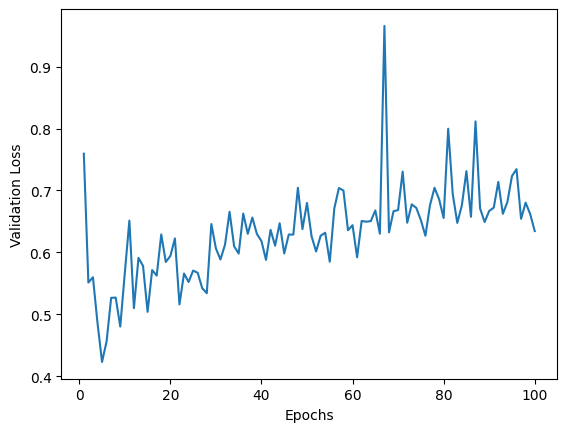

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

In [16]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

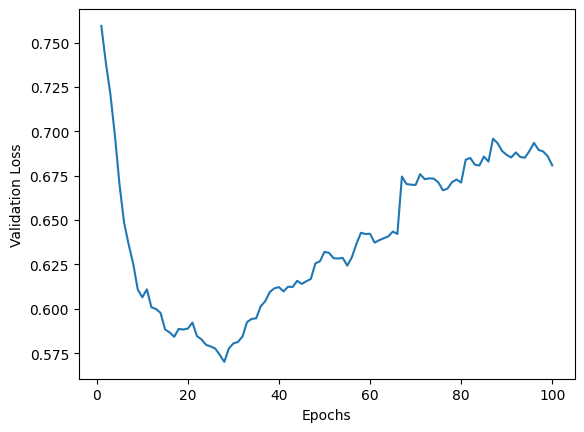

In [17]:
smoothed_loss = smooth_curve(average_loss)

plt.plot(range(1, len(average_loss) + 1), smoothed_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()